In [97]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.models import Word2Vec

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2021)
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

url = './example-question-dataset-master/'



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uyent\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uyent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
thoughts_topics = pd.read_csv(url + 'thoughts_topics.csv')
thoughts_topics.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,topic_id
0,0,2.0,0.2685,"easy, picture, lot, ability, share, live, weir...",It's easy to use and very heavily adopted by o...,Easy To Use
1,1,0.0,0.2715,"people, easily, post, control, access, update,...",Easy access is just about the only thing.,Easy to Access
2,2,0.0,0.2719,"people, easily, post, control, access, update,...",youtube makes it really easy to see what kind ...,Easy to Access
3,3,0.0,0.2636,"people, easily, post, control, access, update,...",Being able to mute/block people. It helps keep...,Easy to Access
4,4,2.0,0.2596,"easy, picture, lot, ability, share, live, weir...",Being able to share content,Easy To Use


In [99]:
agreements = pd.read_csv(url + 'agreements.csv')
agreements.head()


,respondent_id,thought_id,label
0,32,7,Disagree
1,37,3,Agree
2,37,1,Disagree
3,37,14,Disagree
4,37,19,Disagree


In [101]:
thoughts = pd.read_csv(url+ 'thoughts.csv')
thoughts.head()

,id,respondent_id,text
0,0,17,It's easy to use and very heavily adopted by o...
1,1,38,Easy access is just about the only thing.
2,2,23,youtube makes it really easy to see what kind ...
3,3,5,Being able to mute/block people. It helps keep...
4,4,25,Being able to share content


In [103]:
thought_topics = thoughts_topics[['Document_No', 'Dominant_Topic', 'topic_id']]
thought_topics = thought_topics.rename(columns={"Document_No": "id", 
                                                "Dominant_Topic": 'topic_id',
                                               "topic_id" : 'topic'})
thought_topics.head()

,id,topic_id,topic
0,0,2.0,Easy To Use
1,1,0.0,Easy to Access
2,2,0.0,Easy to Access
3,3,0.0,Easy to Access
4,4,2.0,Easy To Use


In [107]:
thoughts_final = thoughts.merge(thought_topics, how='left', on='id')
thoughts_final=thoughts_final.drop(['text'], axis=1)
thoughts_final.head()

,id,respondent_id,topic_id,topic
0,0,17,2.0,Easy To Use
1,1,38,0.0,Easy to Access
2,2,23,0.0,Easy to Access
3,3,5,0.0,Easy to Access
4,4,25,2.0,Easy To Use


## Visualize User's Response Frequency Based On Topics

In [177]:
tt_df = thought_topics.groupby('topic').count()
tt_df = tt_df.drop('id',axis =1)


Text(0.5, 1.0, "Value Count of User's Response Based On Topics")

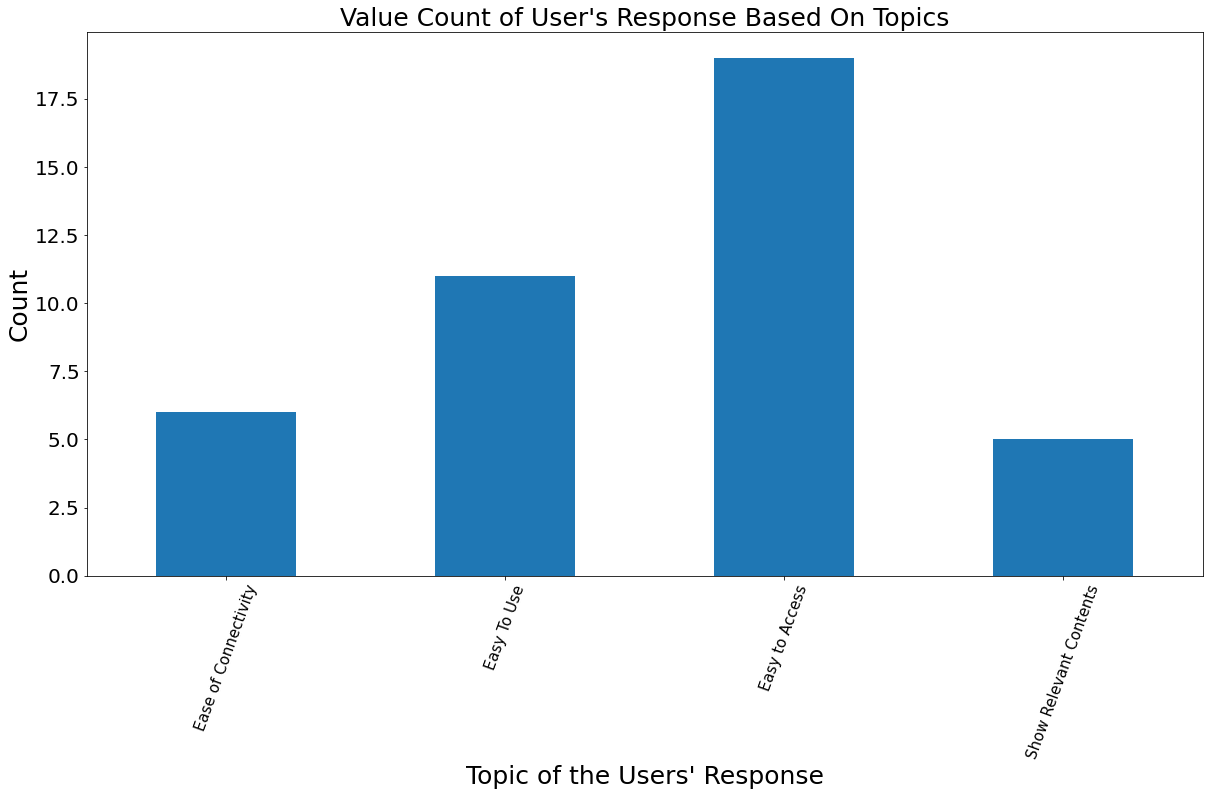

In [178]:
tt_df.plot(kind='bar', figsize=(20,10), legend=False)
plt.xlabel("Topic of the Users' Response", size = 25)
plt.ylabel('Count', size = 25)
plt.xticks(rotation=70, size = 15)
plt.yticks(size = 20)
plt.title("Value Count of User's Response Based On Topics", size =25)


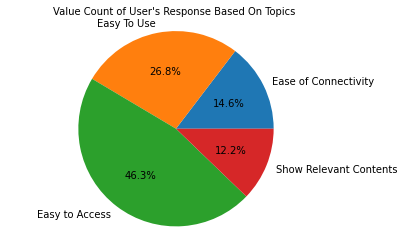

In [202]:
plt.pie(tt_df['topic_id'], labels=tt_df.index,autopct='%1.1f%%',radius = 2.5)
plt.title("Value Count of User's Response Based On Topics", size =10)
plt.axis('equal')
plt.show()

# Merge thoughts dataset with agreeements

In [108]:
# get the new topic for thought id
agree = agreements.merge(thought_topics, left_on='thought_id', right_on='id')
agree

,respondent_id,thought_id,label,id,topic_id,topic
0,32,7,Disagree,7,2.0,Easy To Use
1,1,7,Disagree,7,2.0,Easy To Use
2,38,7,Agree,7,2.0,Easy To Use
3,11,7,Agree,7,2.0,Easy To Use
4,28,7,Disagree,7,2.0,Easy To Use
...,...,...,...,...,...,...
263,10,32,Agree,32,0.0,Easy to Access
264,40,12,Agree,12,0.0,Easy to Access
265,15,12,Agree,12,0.0,Easy to Access
266,33,12,Disagree,12,0.0,Easy to Access


In [109]:
agreements['thought_id'] = agree['topic_id']
agreements

,respondent_id,thought_id,label
0,32,2.0,Disagree
1,37,2.0,Agree
2,37,2.0,Disagree
3,37,2.0,Disagree
4,37,2.0,Disagree
...,...,...,...
263,33,0.0,Agree
264,10,0.0,Agree
265,33,0.0,Agree
266,15,0.0,Disagree


In [111]:
agree_thought = thoughts_final.merge(agreements, how='outer', left_on=['respondent_id'], right_on = ['respondent_id'])
agree_thought = agree_thought.dropna().reset_index(drop=True)
agree_thought

,id,respondent_id,topic_id,topic,thought_id,label
0,0.0,17,2.0,Easy To Use,2.0,Agree
1,0.0,17,2.0,Easy To Use,0.0,Agree
2,0.0,17,2.0,Easy To Use,3.0,Agree
3,0.0,17,2.0,Easy To Use,0.0,Agree
4,1.0,38,0.0,Easy to Access,0.0,Agree
...,...,...,...,...,...,...
261,40.0,8,0.0,Easy to Access,3.0,Disagree
262,40.0,8,0.0,Easy to Access,3.0,Disagree
263,40.0,8,0.0,Easy to Access,1.0,Disagree
264,40.0,8,0.0,Easy to Access,0.0,Agree


## Visualization

### Count on Response with the Same Topics

In [120]:
same_thought = agree_thought[(agree_thought.topic_id == agree_thought.thought_id)].reset_index(drop=True)
same_thought

,id,respondent_id,topic_id,topic,thought_id,label
0,0.0,17,2.0,Easy To Use,2.0,Agree
1,1.0,38,0.0,Easy to Access,0.0,Agree
2,1.0,38,0.0,Easy to Access,0.0,Agree
3,4.0,25,2.0,Easy To Use,2.0,Agree
4,4.0,25,2.0,Easy To Use,2.0,Agree
...,...,...,...,...,...,...
93,40.0,8,0.0,Easy to Access,0.0,Disagree
94,40.0,8,0.0,Easy to Access,0.0,Disagree
95,40.0,8,0.0,Easy to Access,0.0,Disagree
96,40.0,8,0.0,Easy to Access,0.0,Agree


In [127]:
st_df = same_thought.groupby('topic')['label'].apply(lambda x: (x=='Agree').sum()).reset_index(name='count')

In [129]:
st_df['Disagree'] = same_thought.groupby('topic')['label'].apply(lambda x: (x=='Disagree').sum()).reset_index(name='count')['count']

In [144]:
st_df = st_df.rename(columns={'count':'Agree'})
st_df = st_df.set_index('topic')

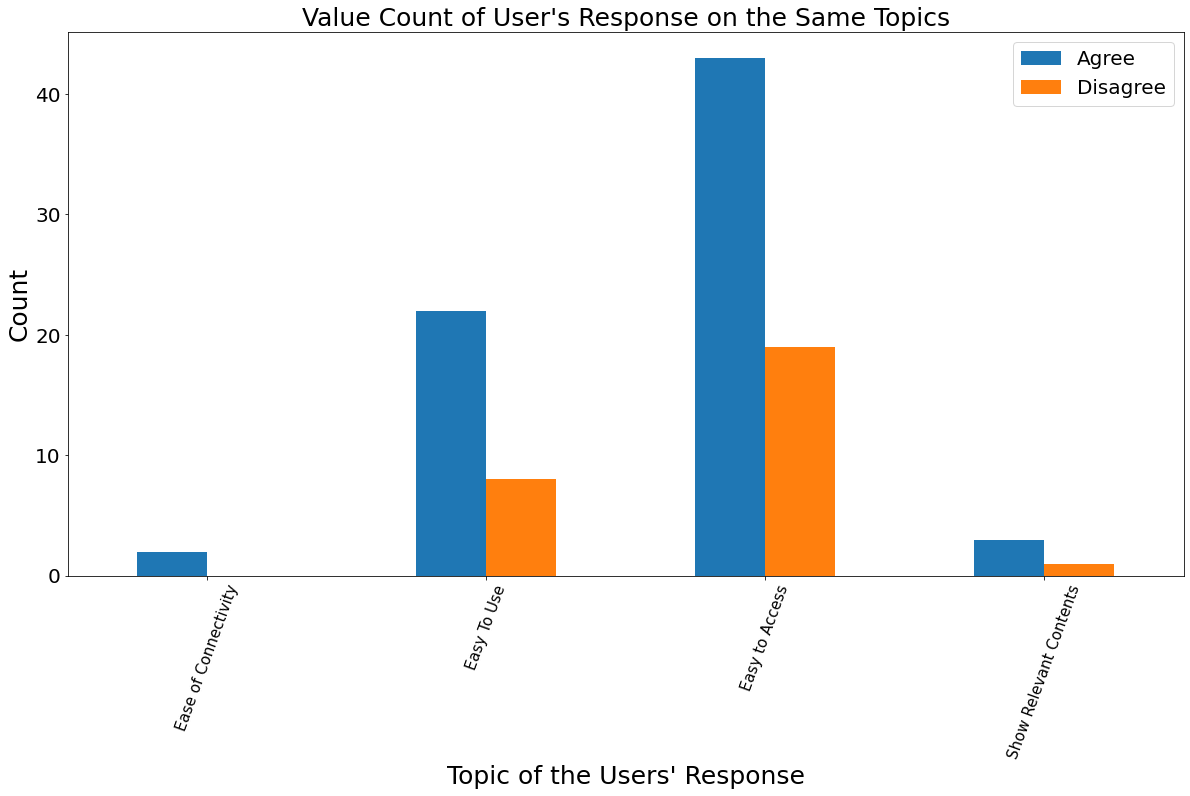

In [154]:
st_df.plot(kind='bar', figsize=(20,10))
plt.xlabel("Topic of the Users' Response", size = 25)
plt.ylabel('Count', size = 25)
plt.xticks(rotation=70, size = 15)
plt.yticks(size = 20)
plt.title("Value Count of User's Response on the Same Topics With ", size =25)
plt.legend(fontsize=20)

### Count on Response with the Different Topics

In [147]:
diff_thought = agree_thought[(agree_thought.topic_id != agree_thought.thought_id)].reset_index(drop=True)
diff_thought

,id,respondent_id,topic_id,topic,thought_id,label
0,0.0,17,2.0,Easy To Use,0.0,Agree
1,0.0,17,2.0,Easy To Use,3.0,Agree
2,0.0,17,2.0,Easy To Use,0.0,Agree
3,1.0,38,0.0,Easy to Access,2.0,Agree
4,1.0,38,0.0,Easy to Access,2.0,Disagree
...,...,...,...,...,...,...
163,40.0,8,0.0,Easy to Access,2.0,Disagree
164,40.0,8,0.0,Easy to Access,2.0,Disagree
165,40.0,8,0.0,Easy to Access,3.0,Disagree
166,40.0,8,0.0,Easy to Access,3.0,Disagree


In [158]:
dt_df = diff_thought.groupby('topic')['label'].apply(lambda x: (x=='Agree').sum()).reset_index(name='count')
dt_df['Disagree'] =diff_thought.groupby('topic')['label'].apply(lambda x: (x=='Disagree').sum()).reset_index(name='count')['count']

In [159]:
dt_df = dt_df.rename(columns={'count':'Agree'})
dt_df = dt_df.set_index('topic')

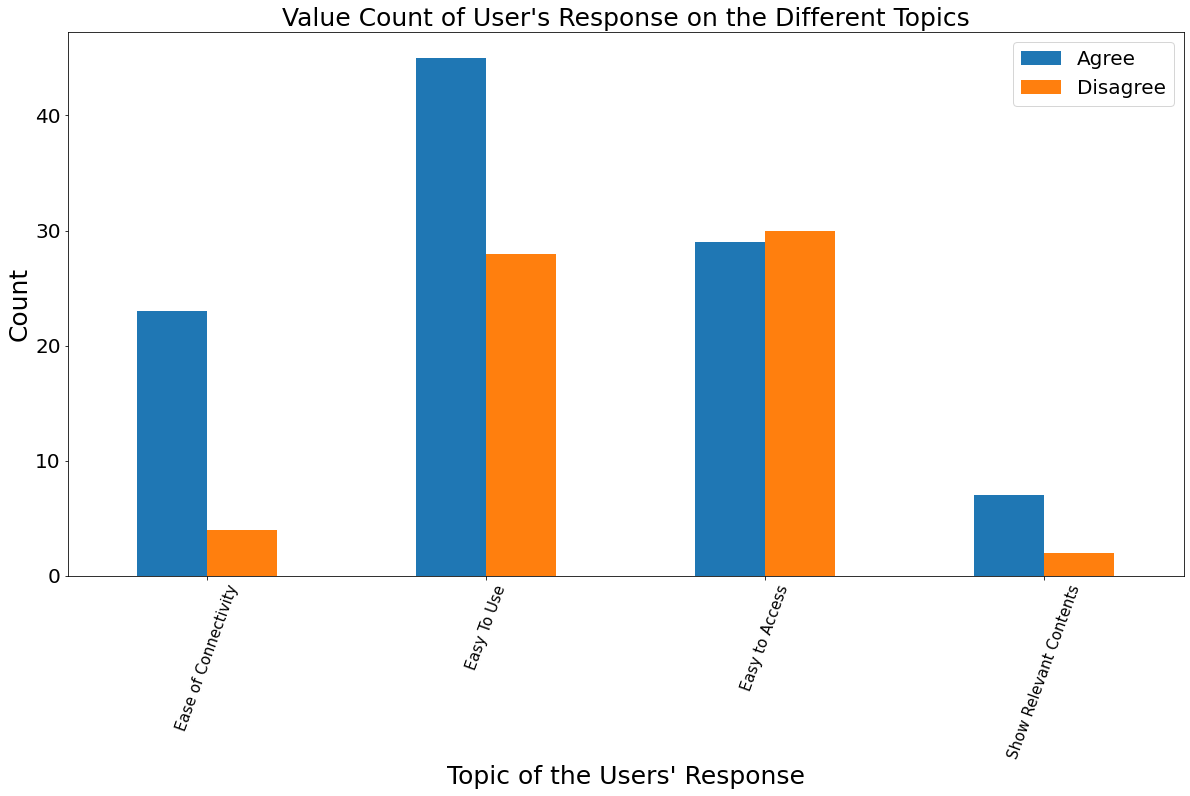

In [160]:
dt_df.plot(kind='bar', figsize=(20,10))
plt.xlabel("Topic of the Users' Response", size = 25)
plt.ylabel('Count', size = 25)
plt.xticks(rotation=70, size = 15)
plt.yticks(size = 20)
plt.title("Value Count of User's Response on the Different Topics", size =25)
plt.legend(fontsize=20)

# Merge Thoughts with Binary Choices

In [218]:
binary_choices = pd.read_csv(url + 'binary_choices.csv')
binary_choices.isnull().sum()
binary_choices


,respondent_id,thought_a_id,thought_b_id,label
0,32,20,14,A
1,29,19,21,A
2,37,6,19,A
3,32,35,5,A
4,37,8,6,B
...,...,...,...,...
142,33,12,29,B
143,33,12,38,B
144,10,38,29,B
145,33,18,5,A


In [219]:
thoughts_final.head()

,id,respondent_id,topic_id,topic
0,0,17,2.0,Easy To Use
1,1,38,0.0,Easy to Access
2,2,23,0.0,Easy to Access
3,3,5,0.0,Easy to Access
4,4,25,2.0,Easy To Use


In [220]:
# get the new topic for thought id
bin_choice_a = binary_choices.merge(thought_topics, left_on='thought_a_id', right_on='id')
bin_choice_b = binary_choices.merge(thought_topics, left_on='thought_b_id', right_on='id')
binary_choices['thought_a_id'] = bin_choice_a['topic_id']
binary_choices['thought_b_id'] = bin_choice_b['topic_id']
binary_choices

,respondent_id,thought_a_id,thought_b_id,label
0,32,0.0,0.0,A
1,29,0.0,2.0,A
2,37,0.0,2.0,A
3,32,0.0,0.0,A
4,37,0.0,0.0,B
...,...,...,...,...
142,33,1.0,1.0,B
143,33,1.0,0.0,B
144,10,3.0,0.0,B
145,33,0.0,1.0,A


In [229]:
# merge thought with binary choices
bin_thoughts = thoughts_final.merge(binary_choices, how='outer', left_on=['respondent_id'], right_on = ['respondent_id'])
bin_thoughts = bin_thoughts.dropna().reset_index(drop=True)
bin_thoughts

,id,respondent_id,topic_id,topic,thought_a_id,thought_b_id,label
0,1,38,0.0,Easy to Access,1.0,3.0,B
1,1,38,0.0,Easy to Access,1.0,2.0,A
2,1,38,0.0,Easy to Access,0.0,3.0,B
3,1,38,0.0,Easy to Access,0.0,3.0,A
4,1,38,0.0,Easy to Access,0.0,3.0,B
...,...,...,...,...,...,...,...
142,39,33,2.0,Easy To Use,1.0,1.0,B
143,39,33,2.0,Easy To Use,1.0,0.0,B
144,39,33,2.0,Easy To Use,0.0,1.0,A
145,40,8,0.0,Easy to Access,0.0,2.0,B


## Visualization

### Users with Consistent Responses

In [244]:
same_bin = bin_thoughts[((bin_thoughts.topic_id == bin_thoughts.thought_a_id) & (bin_thoughts.label == 'A'))
             | ((bin_thoughts.topic_id == bin_thoughts.thought_b_id) & (bin_thoughts.label == 'B'))]

same_bin = same_bin.reset_index(drop=True)
same_bin

,id,respondent_id,topic_id,topic,thought_a_id,thought_b_id,label
0,1,38,0.0,Easy to Access,0.0,3.0,A
1,5,34,0.0,Easy to Access,0.0,0.0,B
2,5,34,0.0,Easy to Access,0.0,0.0,B
3,5,34,0.0,Easy to Access,0.0,0.0,B
4,5,34,0.0,Easy to Access,0.0,0.0,B
...,...,...,...,...,...,...,...
56,35,12,0.0,Easy to Access,3.0,0.0,B
57,35,12,0.0,Easy to Access,2.0,0.0,B
58,37,40,1.0,Ease of Connectivity,0.0,1.0,B
59,37,40,1.0,Ease of Connectivity,0.0,1.0,B


In [257]:
sb_df = same_bin.groupby('topic')['label'].apply(lambda x: (x=='A').sum()).reset_index(name='count')
sb_df['B'] = same_bin.groupby('topic')['label'].apply(lambda x: (x=='B').sum()).reset_index(name='count')['count']
sb_df

,topic,count,B
0,Ease of Connectivity,0,4
1,Easy To Use,5,2
2,Easy to Access,26,24


In [258]:
sb_df = sb_df.rename(columns={'count':'A'})
sb_df = sb_df.set_index('topic')

In [269]:
sum_column = sb_df["A"] + sb_df["B"]
sb_df['sum'] = sum_column
sb_df

,A,B,sum
topic,,,
Ease of Connectivity,0,4,4
Easy To Use,5,2,7
Easy to Access,26,24,50


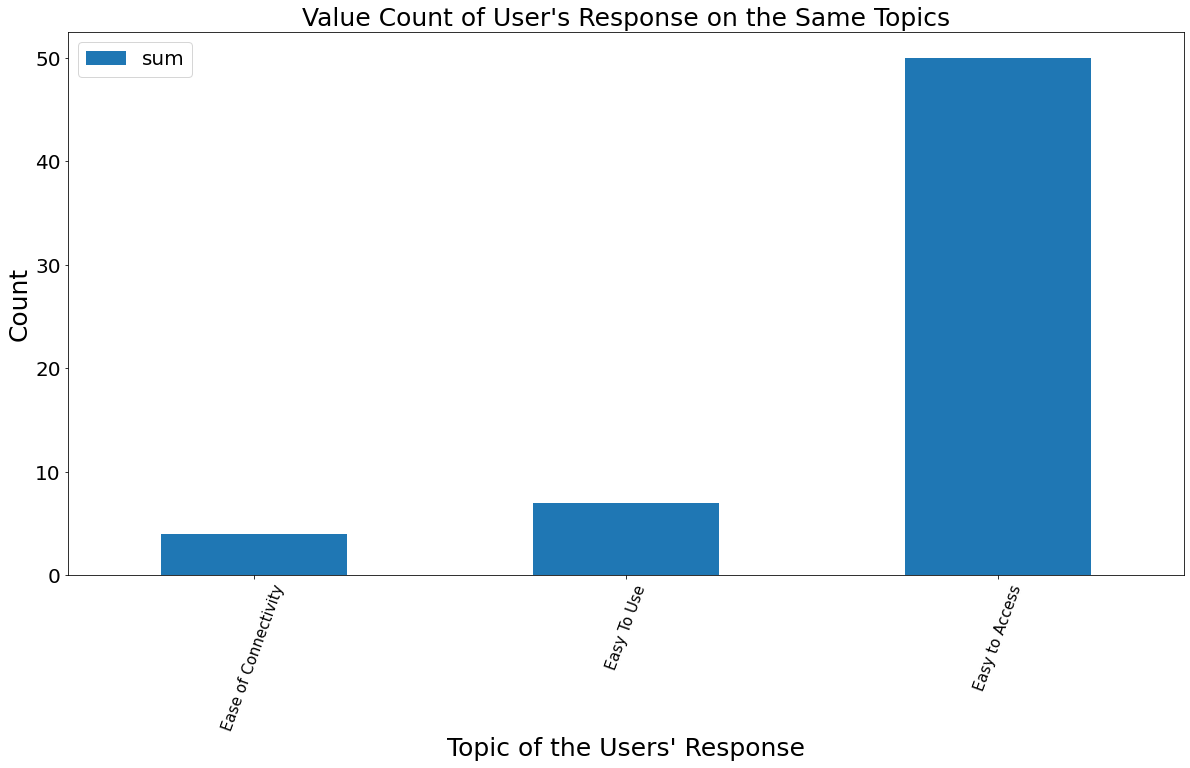

In [261]:
sb_df['sum'].plot(kind='bar', figsize=(20,10))
plt.xlabel("Topic of the Users' Response", size = 25)
plt.ylabel('Count', size = 25)
plt.xticks(rotation=70, size = 15)
plt.yticks(size = 20)
plt.title("Value Count of User's Response on the Same Topics", size =25)
plt.legend(fontsize=20)

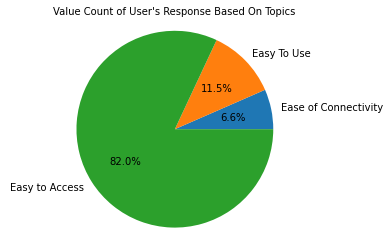

In [270]:
plt.pie(sb_df['sum'], labels=sb_df.index,autopct='%1.1f%%',radius = 2.5)
plt.title("Value Count of User's Response Based On Topics", size =10)
plt.axis('equal')
plt.show()

### Users with Different Responses

In [263]:
diff_bin = bin_thoughts[~((bin_thoughts.topic_id == bin_thoughts.thought_a_id) & (bin_thoughts.label == 'A'))
             | ((bin_thoughts.topic_id == bin_thoughts.thought_b_id) & (bin_thoughts.label == 'B'))]

diff_bin = diff_bin.reset_index(drop=True)
diff_bin

,id,respondent_id,topic_id,topic,thought_a_id,thought_b_id,label
0,1,38,0.0,Easy to Access,1.0,3.0,B
1,1,38,0.0,Easy to Access,1.0,2.0,A
2,1,38,0.0,Easy to Access,0.0,3.0,B
3,1,38,0.0,Easy to Access,0.0,3.0,B
4,5,34,0.0,Easy to Access,0.0,0.0,B
...,...,...,...,...,...,...,...
111,39,33,2.0,Easy To Use,3.0,1.0,B
112,39,33,2.0,Easy To Use,1.0,1.0,B
113,39,33,2.0,Easy To Use,1.0,0.0,B
114,39,33,2.0,Easy To Use,0.0,1.0,A
